In [127]:
import uproot
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

## Define Function for Invariant Mass

## Fill particle information in to NumpyArray 

In [264]:
def MyFunction(file):
    GenParticle = np.array([file["Particle.Status"].array(),
                            file["Particle.PID"].array(),
                            file["Particle.M1"].array(),
                            file["Particle.M2"].array(),
                            file["Particle.D1"].array(),
                            file["Particle.D2"].array(),
                            file["Particle.PT"].array(),
                            file["Particle.Eta"].array(),
                            file["Particle.Phi"].array(),
                            file["Particle.Mass"].array()])

    Jet = np.array([file["Jet.PT"].array(),
                            file["Jet.Eta"].array(),
                            file["Jet.Phi"].array(),
                            file["Jet.Mass"].array()
                           ])

    Event_Weight = np.array(file["Event.Weight"].array())

    return GenParticle, Jet, Event_Weight


def Preselection(Jet):
    twojet_invariantmass = []
    survived_list = []
    for i in range(len(Jet[0])):
        if len(Jet[0][i]) < 2:
                continue

        if Jet[0][i][0] < 440 or Jet[0][i][1] < 60:
            continue

        if np.abs(Jet[1][i][0]-Jet[1][i][1]) < 1.2:
            continue

        twojet_invariantmass.append(M(Jet[0][i][0],Jet[1][i][0],Jet[2][i][0],Jet[3][i][0],Jet[0][i][1],Jet[1][i][1],Jet[2][i][1],Jet[3][i][1]))

        survived_list.append(i)

    print("There are {} events.".format(len(twojet_invariantmass)))
    
    return np.array(twojet_invariantmass), np.array(survived_list)


def Check_r_inv(GenParticle):
    invis_count, vis_count = 0, 0
    for i in range(len(GenParticle[1])):
    # for i in range(10000,20000):
        for j in range(len(GenParticle[0][i])):
            PID = GenParticle[1][i][j]
            D1 = GenParticle[4][i][j]
            D2 = GenParticle[5][i][j]
            
            if (abs(PID) == 4900111) and (abs(GenParticle[1][i][D1]) != 4900111) and (abs(GenParticle[1][i][D2]) != 4900111):
                if (abs(GenParticle[1][i][D1]) != 3) and (abs(GenParticle[1][i][D2]) != 3):
                    invis_count += 1

            if (abs(PID) == 4900111) and (abs(GenParticle[1][i][D1]) != 4900111) and (abs(GenParticle[1][i][D2]) != 4900111):
                if (abs(GenParticle[1][i][D1]) == 3) or (abs(GenParticle[1][i][D2]) == 3):
                    vis_count += 1

            if (abs(PID) == 4900113) and (abs(GenParticle[1][i][D1]) != 4900113) and (abs(GenParticle[1][i][D2]) != 4900113):
                if (abs(GenParticle[1][i][D1]) > 490000) or (abs(GenParticle[1][i][D2]) > 490000):
                    invis_count += 1

            if (abs(PID) == 4900113) and (abs(GenParticle[1][i][D1]) != 4900113) and (abs(GenParticle[1][i][D2]) != 4900113):
                if (abs(GenParticle[1][i][D1]) < 6) or (abs(GenParticle[1][i][D2]) < 6):
                    vis_count += 1

    print("There are {} events.".format(len(GenParticle[0])))
    print("There are Dark meson {}  decay into invisible particle.".format(invis_count))
    print("There are Dark meson {}  decay into visible particle.".format(vis_count))
    print("r_inv = {:^4.4f} ".format(invis_count/(invis_count+vis_count)))
    return invis_count/(invis_count+vis_count)
    
def CountNdarks(GenParticle):
    Ndark = 0
    for i in range(len(GenParticle[1])):
        for j in range(len(GenParticle[0][i])):
            PID = GenParticle[1][i][j]
            D1 = GenParticle[4][i][j]
            D2 = GenParticle[5][i][j]

            if (abs(PID) == 4900211) and (D1 == -1) and (D2 == -1):
                    Ndark += 1

            if (abs(PID) == 4900213) and (D1 == -1) and (D2 == -1):
                    Ndark += 1

    print("There are {} events.".format(len(GenParticle[0])))
    print("There are {} stable Dark mesons.".format(Ndark))
    print("Average = {:^4.4f} ".format(Ndark/len(GenParticle[0])))
    return Ndark/len(GenParticle[0])

In [238]:
def M(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    return np.sqrt((e1+e2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2)
    

## Import File

In [269]:
roor_file_path = "/home/Storage/MG5_Study_Group/ROOT/Scan_rinv_alpha_v2/SVJ_0_10.root"
# filepath_0 = "/home/Storage/MG5_Study_Group/ROOT/sig_schannel_up2jets_mz_1500_wz_auto_0.root"
# filepath_03 = "/home/Storage/MG5_Study_Group/ROOT/sig_schannel_up2jets_mz_1500_wz_auto_03.root"
# filepath_05 = "/home/Storage/MG5_Study_Group/ROOT/sig_schannel_up2jets_mz_1500_wz_auto_05.root"
# filepath_1 = "/home/Storage/MG5_Study_Group/ROOT/sig_schannel_up2jets_mz_1500_wz_auto_1.root"

file_0 = uproot.open(roor_file_path)["Delphes;1"]
# file_03 = uproot.open(filepath_03)["Delphes;1"]
# file_05 = uproot.open(filepath_05)["Delphes;1"]
# file_1 = uproot.open(filepath_1)["Delphes;1"]

In [ ]:
file_0.show()

In [270]:
GenParticle_0, Jet_0, Event_Weight_0 = MyFunction(file_0)
# GenParticle_03, Jet_03, Event_Weight_03 = MyFunction(file_03)
# GenParticle_05, Jet_05, Event_Weight_05 = MyFunction(file_05)
# GenParticle_1, Jet_1, Event_Weight_1 = MyFunction(file_1)

# Check the Event Shape

In [271]:
np.array(GenParticle_0).shape

(10, 5270)

## Check the $r_{inv}$

In [273]:
Check_r_inv(GenParticle_0[:10])
# Check_r_inv(GenParticle_03)
# Check_r_inv(GenParticle_05)
# Check_r_inv(GenParticle_1)

There are 5270 events.
There are Dark meson 0  decay into invisible particle.
There are Dark meson 27034  decay into visible particle.
r_inv = 0.0000 


0.0

In [272]:
CountNdarks(GenParticle_0)

5.190512333965844

In [265]:
ndark_2 = []
for i in [10,50,100,150,200,250,300,350]:
        roor_file_path = "/home/Storage/MG5_Study_Group/ROOT/Scan_rinv_alpha_v2/SVJ_8_"+str(i)+".root"
        file = uproot.open(roor_file_path)["Delphes;1"]
        GenParticle, _, _ = MyFunction(file)
        ndark_2.append(CountNdarks(GenParticle))

In [266]:
ndark_2

[5.124576590139255,
 5.3375071143995445,
 4.545735237360093,
 3.8910798122065726,
 3.440720168550086,
 3.123426639113282,
 2.8885513575090185,
 2.7248707639287764]

In [260]:
print(ndark_2)

[1.3085628064881176, 1.3332067590658818, 1.1215987990242071, 0.9672789896670494, 0.8595832551154496, 0.7923921271763815, 0.7255125284738041, 0.6889272692381501]


In [274]:
ndark = np.load("./ndark_10_v2.npy")
print(ndark.shape)
print(ndark)

(8, 11)
[[1.28538899 1.30213749 1.29320988 1.28461538 1.32818164 1.27377358
  1.28684566 1.28181993 1.29205871 1.30856281 1.28650085]
 [1.33593304 1.30825792 1.33214953 1.32178877 1.33352294 1.31124031
  1.34588325 1.345101   1.34642383 1.33320676 1.29567034]
 [1.11969407 1.11960069 1.12942989 1.1107454  1.12803702 1.13233924
  1.13720317 1.14690332 1.13932844 1.1215988  1.12487843]
 [0.97311525 0.97242718 0.96618541 0.96668538 0.99482461 0.95476145
  0.96620202 0.95505405 1.00150235 0.96727899 0.96480447]
 [0.82863628 0.86229872 0.85419847 0.85790885 0.86335168 0.87420901
  0.85435407 0.88173481 0.8666922  0.85958326 0.87354815]
 [0.78414428 0.78022395 0.75768049 0.77432791 0.77621459 0.76473955
  0.7808642  0.77617398 0.79090738 0.79239213 0.777842  ]
 [0.72086466 0.705325   0.72322275 0.73832302 0.72593831 0.71969271
  0.73041998 0.71784627 0.71881526 0.72551253 0.71203193]
 [0.67806918 0.70789524 0.69067877 0.68053972 0.67075935 0.68686481
  0.69321422 0.68355835 0.69653456 0.68892

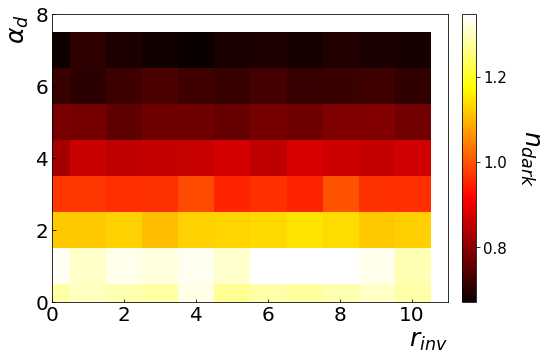

In [282]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib import cm


fig, ax = plt.subplots(1,1, figsize=(20,5))
plt.imshow(ndark,cmap="hot",origin='lower')
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

cax = plt.axes([0.61, 0.1, 0.01, 0.8])
cbar = plt.colorbar(cax=cax)  
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.set_major_locator(MaxNLocator(4))
cbar.set_label("$n_{dark}$", rotation=270, fontsize=25, labelpad=35, y=0.5)

ax.set_ylabel("$\\alpha_d$", fontsize=25, horizontalalignment='right',y=1)
# ax.set_xticks([0,20,40])
# ax.set_xticklabels(["-5","0","5"], fontsize=25, rotation=0, verticalalignment='top', horizontalalignment="center")
ax.set_xlabel("$r_{inv}$", fontsize=25,horizontalalignment='right',x=1)

ax.tick_params(axis='x', direction="in", labelsize=20)
ax.tick_params(axis='y', direction="in", labelsize=20)

#plt.text(x=-2,y=0.05, s=figtitle[i], rotation=0 ,fontsize=30)
#plt.text(x=-60,y=-4, s=figtitle[i], rotation=0 ,fontsize=30)
        
ax.set_xlim((0,11))
ax.set_ylim((0,8))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

## Print the Truth Record in an Event

In [276]:
GenParticle = GenParticle_0
print("There are {} information in this event.".format(len(GenParticle[0][0])))
print("GenParticle Information")
print("{:^5}{:^7}{:^7}{:^7}{:^7}{:^7}{:^7}{:^8}{:^8}{:^8}{:^8}".format("#","Status","PID", "M1", "M2", "D1", "D2", "PT", "Eta","Phi", "Mass"))

index = 0 ## which event you want to print out

for j in range(len(GenParticle[0][index])):
    print("{:^5}{:^7}{:^7}{:^7}{:^7}{:^7}{:^7}{:^8.5}{:^8.5}{:^8.5}{:^8.5}".format( \
        j, GenParticle[0][index][j],  GenParticle[1][index][j], GenParticle[2][index][j], GenParticle[3][index][j],
        GenParticle[4][index][j], GenParticle[5][index][j], GenParticle[6][index][j], GenParticle[7][index][j] ,GenParticle[8][index][j], GenParticle[9][index][j]))



There are 1130 information in this event.
GenParticle Information
  #  Status   PID    M1     M2     D1     D2      PT     Eta     Phi     Mass  
  0     4    2212    -1     -1     296    -1     0.0    999.9    0.0   0.93827 
  1     4    2212    -1     -1     297    -1     0.0    -999.9   0.0   0.93827 
  2    21     -1     31     31      4      5     0.0    999.9    0.0     0.0   
  3    21      1     32     -1      4      5     0.0    -999.9   0.0     0.0   
  4    23   4900101   2      3      8      8    295.43 -0.464870.32415   10.0  
  5    23   -4900101   2      3      6      7    295.43 -2.2828 -2.8174   10.0  
  6    51   -4900101   5     -1     11     11    288.45 -2.2727  -2.893   10.0  
  7    51   4900021   5     -1      9     10    21.83  -1.5904 -1.3097   0.0   
  8    52   4900101   4      4     14     14    289.01 -0.4649 0.32415   10.0  
  9    51   4900021   7     -1     12     13    45.278 -1.8781 -2.1287   0.0   
 10    51   4900021   7     -1     17     17    9.62

In [235]:
twojet_invariantmass_0, survived_list_0 = Preselection(Jet_0)
twojet_invariantmass_03, survived_list_03 = Preselection(Jet_03)
twojet_invariantmass_05, survived_list_05 = Preselection(Jet_05)
twojet_invariantmass_1, survived_list_1 = Preselection(Jet_1)

There are 660 events.
There are 356 events.
There are 272 events.
There are 84 events.


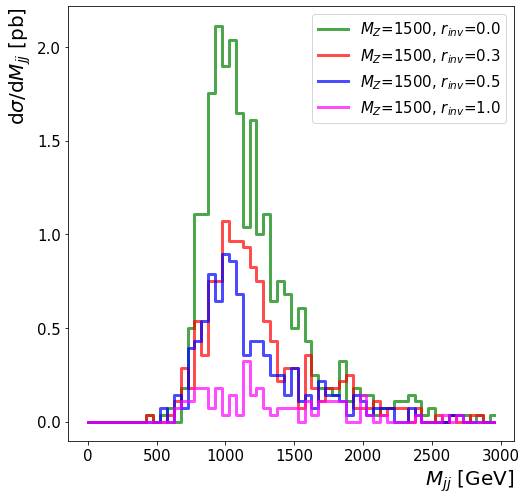

In [236]:
plt.figure(figsize=(8,8)) # plotsize

weight_0 = Event_Weight_0[survived_list_0]/20000*37*1000
weight_03 = Event_Weight_03[survived_list_03]/20000*37*1000
weight_05 = Event_Weight_05[survived_list_05]/20000*37*1000
weight_1 = Event_Weight_1[survived_list_1]/20000*37*1000

bin_size = np.linspace(0,3000,61)


hist_0, bins_0 = np.histogram(twojet_invariantmass_0, bins=bin_size, weights = weight_0)
plt.step(bins_0[:-1], hist_0.astype(np.float32)/50, color = "green", where='mid',linewidth=3, alpha=0.7,label="$M_Z$=1500, $r_{inv}$=0.0") 

hist_03, bins_03 = np.histogram(twojet_invariantmass_03, bins=bin_size, weights = weight_03)
plt.step(bins_03[:-1], hist_03.astype(np.float32)/50, color = "red", where='mid',linewidth=3, alpha=0.7,label="$M_Z$=1500, $r_{inv}$=0.3") 

hist_05, bins_05 = np.histogram(twojet_invariantmass_05, bins=bin_size, weights = weight_05)
plt.step(bins_05[:-1], hist_05.astype(np.float32)/50, color = "blue", where='mid',linewidth=3, alpha=0.7,label="$M_Z$=1500, $r_{inv}$=0.5") 

hist_1, bins_1 = np.histogram(twojet_invariantmass_1, bins=bin_size, weights = weight_1)
plt.step(bins_1[:-1], hist_1.astype(np.float32)/50, color = "magenta", where='mid',linewidth=3, alpha=0.7,label="$M_Z$=1500, $r_{inv}$=1.0") 



# plt.yscale('log') 
plt.xlabel("$M_{jj}$ [GeV]" , fontsize=20, horizontalalignment='right',x=1)  # plot x-axis label
plt.ylabel("d$\sigma$/d$M_{jj}$ [pb]", fontsize=20, horizontalalignment='right',y=1)  # plot y-axis label
plt.xticks(fontsize=15)   # set x-ticks size
plt.yticks(fontsize=15)   # set y-ticks size 
plt.legend(bbox_to_anchor=(1, 1),ncol=1,fontsize=15) # plot label tag
# plt.savefig("./invariant_mass_SVJ.png")  #save figure as png
plt.show()

In [217]:
aaa = [10,50,100,150,200,250,300,350]
# print(aaa)
for i, lambda_d in enumerate(aaa):
    print("lambda: {:^7.2f}  alpha:{:^7.2f}".format(aaa[i],np.pi*2/((11./3.*2-2./3.*2)*np.log(1000./lambda_d))))


lambda:  10.00   alpha: 0.23  
lambda:  50.00   alpha: 0.35  
lambda: 100.00   alpha: 0.45  
lambda: 150.00   alpha: 0.55  
lambda: 200.00   alpha: 0.65  
lambda: 250.00   alpha: 0.76  
lambda: 300.00   alpha: 0.87  
lambda: 350.00   alpha: 1.00  
